In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [21]:
df = pd.read_excel("../data/Data Responden Artikel Ilmiah Callista dan Alexandra.xlsx")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 29 columns):
 #   Column                                                                                    Non-Null Count  Dtype 
---  ------                                                                                    --------------  ----- 
 0   Nama                                                                                      150 non-null    object
 1   Jenis Kelamin                                                                             150 non-null    object
 2   Usia                                                                                      150 non-null    int64 
 3   Jenjang Pendidikan                                                                        150 non-null    object
 4   1. Saya menonton TikTok setiap hari.                                                      150 non-null    int64 
 5   2. Saya tidak bisa mengontrol waktu yang saya habiskan di TikTok

In [22]:
#drop name column if present
df = df.drop(columns=["Nama "], errors="ignore")

#check missing values
df.isnull().sum()

#clean column names
df.columns = df.columns.str.strip()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 28 columns):
 #   Column                                                                                   Non-Null Count  Dtype 
---  ------                                                                                   --------------  ----- 
 0   Jenis Kelamin                                                                            150 non-null    object
 1   Usia                                                                                     150 non-null    int64 
 2   Jenjang Pendidikan                                                                       150 non-null    object
 3   1. Saya menonton TikTok setiap hari.                                                     150 non-null    int64 
 4   2. Saya tidak bisa mengontrol waktu yang saya habiskan di TikTok.                        150 non-null    int64 
 5   3. Saya sering menonton TikTok dalam waktu lama tanpa sadar.           

In [23]:
#encode demographic variables
df['Gender'] = df['Jenis Kelamin'].map({'Laki-laki': 0, 'Perempuan': 1})

df['Education_Level'] = df['Jenjang Pendidikan'].map({
    'SMA/SMK': 0,
    'Mahasiswa': 1,
})

#rename usia -> age
df = df.rename(columns={"Usia": "Age"}) 

In [24]:
#Q1-6
exposure_cols = [
    col for col in df.columns
    if col.startswith(tuple(f"{i}." for i in range(1, 7)))
]

#Q7-18 (attention-related difficulties NOT attention span)
attention_cols = [
    col for col in df.columns
    if col.startswith(tuple(f"{i}." for i in range(7, 19)))
]

#Q19-25 (academic functioning NOT overall academic performance)
academic_cols = [
    col for col in df.columns
    if col.startswith(tuple(f"{i}." for i in range(19, 26)))
]

len(exposure_cols), len(attention_cols), len(academic_cols)

(6, 12, 7)

In [25]:

#index construction
df["Exposure_Index"] = df[exposure_cols].mean(axis=1)
df["Attention_Difficulty_Index"] = df[attention_cols].mean(axis=1)
df["Academic_Functioning_Index"] = df[academic_cols].mean(axis=1)

df[["Exposure_Index", "Attention_Difficulty_Index", "Academic_Functioning_Index"]].describe()

,Exposure_Index,Attention_Difficulty_Index,Academic_Functioning_Index
count,150.000000,150.000000,150.000000
mean,3.190000,2.782778,3.148571
std,0.679965,0.736353,0.652848
min,1.333333,1.416667,1.428571
25%,2.833333,2.104167,2.714286
50%,3.333333,2.916667,3.428571
75%,3.666667,3.500000,3.571429
max,4.000000,3.750000,3.857143


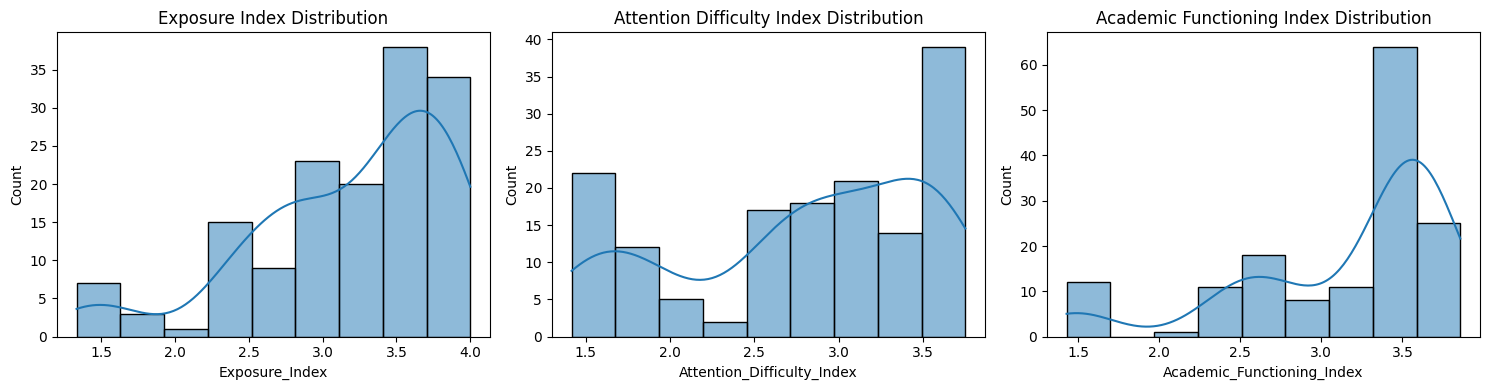

In [26]:
#index distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df["Exposure_Index"], kde=True, ax=axes[0])
axes[0].set_title("Exposure Index Distribution")

sns.histplot(df["Attention_Difficulty_Index"], kde=True, ax=axes[1])
axes[1].set_title("Attention Difficulty Index Distribution")

sns.histplot(df["Academic_Functioning_Index"], kde=True, ax=axes[2])
axes[2].set_title("Academic Functioning Index Distribution")

plt.tight_layout()
plt.show()

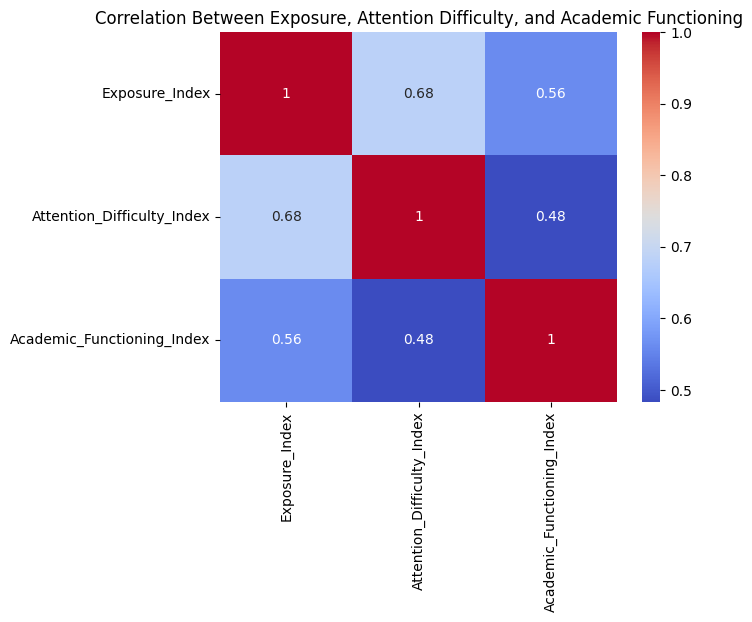

In [27]:
#correlation analysis
corr = df[[
    "Exposure_Index",
    "Attention_Difficulty_Index",
    "Academic_Functioning_Index"
]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Exposure, Attention Difficulty, and Academic Functioning")
plt.show()

In [28]:
#regression models
#model a: attention difficulty index ~ exposure index
X = sm.add_constant(df["Exposure_Index"])
y = df["Attention_Difficulty_Index"]
model_a = sm.OLS(y, X).fit()
print(model_a.summary())

#model b: academic functioning index ~ exposure index
X = sm.add_constant(df["Exposure_Index"])
y = df["Academic_Functioning_Index"]
model_b = sm.OLS(y, X).fit()
print(model_b.summary())

#model c: academic functioning index ~ attention difficulty index
X = sm.add_constant(df["Attention_Difficulty_Index"])
y = df["Academic_Functioning_Index"]
model_c = sm.OLS(y, X).fit()
print(model_c.summary())

#model d: academic functioning index ~ exposure index + attention difficulty index
X = sm.add_constant(
    df[["Exposure_Index", "Attention_Difficulty_Index"]]
)
y = df["Academic_Functioning_Index"]
model_d = sm.OLS(y, X).fit()
print(model_d.summary())

                                OLS Regression Results                                
Dep. Variable:     Attention_Difficulty_Index   R-squared:                       0.466
Model:                                    OLS   Adj. R-squared:                  0.463
Method:                         Least Squares   F-statistic:                     129.3
Date:                        Mon, 12 Jan 2026   Prob (F-statistic):           6.34e-22
Time:                                01:50:08   Log-Likelihood:                -119.35
No. Observations:                         150   AIC:                             242.7
Df Residuals:                             148   BIC:                             248.7
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [29]:
#predictive modeling
features = [
    "Exposure_Index",
    "Attention_Difficulty_Index",
    "Age",
    "Education_Level",
    "Gender"
]

X = df[features]
y = df["Academic_Functioning_Index"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

#random forest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

#gradient boosting regressor
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)

gbr_r2 = r2_score(y_test, gbr_preds)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_preds))

#xgboost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "XGBoost"],
    "Test R²": [
        r2_score(y_test, lr_preds),
        r2_score(y_test, rf_preds),
        gbr_r2,
        xgb_r2
    ],
    "Test RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_preds)),
        np.sqrt(mean_squared_error(y_test, rf_preds)),
        gbr_rmse,
        xgb_rmse
    ]
})

results

,Model,Test R²,Test RMSE
0,Linear Regression,0.053762,0.636645
1,Random Forest,0.365705,0.521246
2,Gradient Boosting,0.320843,0.539364
3,XGBoost,0.359078,0.523962


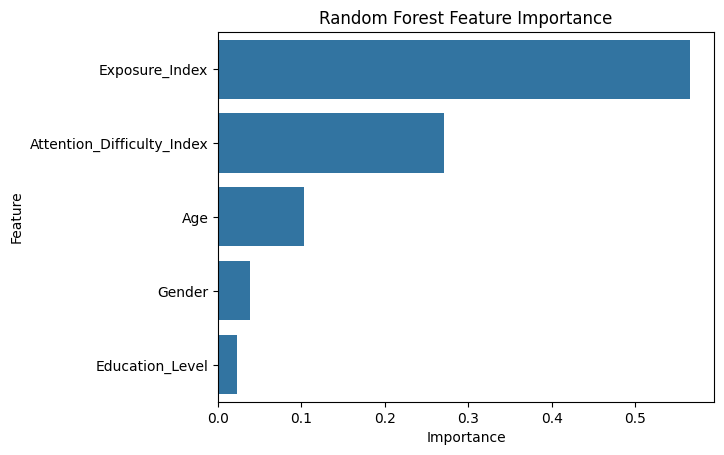

In [30]:
#feature importance
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df
)
plt.title("Random Forest Feature Importance")
plt.show()

In [31]:
df.to_csv("../data/processed.csv", index=False)

In [32]:
pls_df = df[
    exposure_cols +
    attention_cols +
    academic_cols +
    ["Age", "Education_Level", "Gender"]
]

pls_df.to_csv("../data/pls_data.csv", index=False)

df_pls = pls_df.sample(n=100, random_state=42)
df_pls.to_csv("../data/pls_data_100.csv", index=False)